In [1]:
# Import notwendiger Bibliotheken
import nussl
from common import data, viz
from IPython.display import Audio
import IPython
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import librosa
import os
from scipy import signal
import matplotlib.pyplot as plt
import stempeg
import pickle
import zipfile
from tensorflow.keras.optimizers import Adam

c:\Users\Lukas\AppData\Local\Programs\Python\Python38\lib\site-packages\ignite\handlers\checkpoint.py:16: DeprecationWarning: `TorchScript` support for functional optimizers is deprecated and will be removed in a future PyTorch release. Consider using the `torch.compile` optimizer instead.
  from torch.distributed.optim import ZeroRedundancyOptimizer


In [2]:
with zipfile.ZipFile('C:\\Users\\Lukas\\Desktop\\TH Nürnberg\\Projekt\\netz\\Daten\\Training_vocals_12679_co=0.8_th=5000.zip', 'r') as zipf:
    zipf.extractall()  # Entpackt alle Dateien
    
    # Lade die Arrays
    X_train = np.load('X_train.npy', allow_pickle=True)
    y_train = np.load('y_train.npy', allow_pickle=True)

print(X_train.shape)
print(y_train.shape)

os.remove('X_train.npy')
os.remove('y_train.npy')

(12679, 512, 128, 1)
(12679, 512, 128, 1)


In [ ]:
def create_ideal_mask(source_magnitude, mix_magnitude):
    epsilon = 1e-8
    ideal_mask = source_magnitude / (mix_magnitude + epsilon)
    
    return ideal_mask

In [ ]:
y_masks = []

for i in range(X_train.shape[0]):
    y_masks.append(create_ideal_mask(y_train[i], X_train[i]))

y_masks = np.array(y_masks)

print(y_masks.shape)

In [3]:
def build_masking_network(input_shape=(512, 128, 1)):
    inputs = tf.keras.Input(shape=input_shape)

    # Encoder
    x = layers.Conv2D(64, (5, 5), strides=(2, 2), padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.Conv2D(128, (5, 5), strides=(2, 2), padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.Conv2D(256, (5, 5), strides=(2, 2), padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    # Decoder
    x = layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    outputs = layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', activation='sigmoid')(x) # Maske zwischen 0 und 1
    model = models.Model(inputs, outputs)
    return model

def build_unet(input_shape=(512, 128, 1)):
    inputs = tf.keras.Input(shape=input_shape)

    # Encoder
    conv1 = layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same')(inputs)
    conv1 = layers.BatchNormalization()(conv1)
    conv1 = layers.ReLU()(conv1)
    conv1 = layers.Dropout(0.5)(conv1)

    conv2 = layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same')(conv1)
    conv2 = layers.BatchNormalization()(conv2)
    conv2 = layers.ReLU()(conv2)
    conv2 = layers.Dropout(0.5)(conv2)

    conv3 = layers.Conv2D(256, (5, 5), strides=(2, 2), padding='same')(conv2)
    conv3 = layers.BatchNormalization()(conv3)
    conv3 = layers.ReLU()(conv3)
    conv3 = layers.Dropout(0.5)(conv3)

    conv4 = layers.Conv2D(512, (5, 5), strides=(2, 2), padding='same')(conv3)
    conv4 = layers.BatchNormalization()(conv4)
    conv4 = layers.ReLU()(conv4)

    conv5 = layers.Conv2D(1024, (5, 5), strides=(2, 2), padding='same')(conv4)
    conv5 = layers.BatchNormalization()(conv5)
    conv5 = layers.ReLU()(conv5)

    # Decoder
    up6 = layers.Conv2DTranspose(512, (5, 5), strides=(2, 2), padding='same')(conv5)
    up6 = layers.BatchNormalization()(up6)
    up6 = layers.ReLU()(up6)
    up6 = layers.Concatenate()([up6, conv4])

    up7 = layers.Conv2DTranspose(256, (5, 5), strides=(2, 2), padding='same')(up6)
    up7 = layers.BatchNormalization()(up7)
    up7 = layers.ReLU()(up7)
    up7 = layers.Concatenate()([up7, conv3])

    up8 = layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same')(up7)
    up8 = layers.BatchNormalization()(up8)
    up8 = layers.ReLU()(up8)
    up8 = layers.Concatenate()([up8, conv2])

    up9 = layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same')(up8)
    up9 = layers.BatchNormalization()(up9)
    up9 = layers.ReLU()(up9)
    up9 = layers.Concatenate()([up9, conv1])

    outputs = layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', activation='sigmoid')(up9)

    model = tf.keras.Model(inputs, outputs)
    return model

def build_autoencoder(input_shape=(512, 128, 1)):
    inputs = tf.keras.Input(shape=input_shape)

    # Encoder
    conv1 = layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same')(inputs)
    conv1 = layers.BatchNormalization()(conv1)
    conv1 = layers.ReLU()(conv1)
    #conv1 = layers.Dropout(0.5)(conv1)

    conv2 = layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same')(conv1)
    conv2 = layers.BatchNormalization()(conv2)
    conv2 = layers.ReLU()(conv2)
    #conv2 = layers.Dropout(0.5)(conv2)

    conv3 = layers.Conv2D(256, (5, 5), strides=(2, 2), padding='same')(conv2)
    conv3 = layers.BatchNormalization()(conv3)
    conv3 = layers.ReLU()(conv3)
    #conv3 = layers.Dropout(0.5)(conv3)

    conv4 = layers.Conv2D(512, (5, 5), strides=(2, 2), padding='same')(conv3)
    conv4 = layers.BatchNormalization()(conv4)
    conv4 = layers.ReLU()(conv4)

    conv5 = layers.Conv2D(1024, (5, 5), strides=(2, 2), padding='same')(conv4)
    conv5 = layers.BatchNormalization()(conv5)
    conv5 = layers.ReLU()(conv5)

    # Decoder
    up6 = layers.Conv2DTranspose(512, (5, 5), strides=(2, 2), padding='same')(conv5)
    up6 = layers.BatchNormalization()(up6)
    up6 = layers.ReLU()(up6)
    #up6 = layers.Concatenate()([up6, conv4])

    up7 = layers.Conv2DTranspose(256, (5, 5), strides=(2, 2), padding='same')(up6)
    up7 = layers.BatchNormalization()(up7)
    up7 = layers.ReLU()(up7)
    #up7 = layers.Concatenate()([up7, conv3])

    up8 = layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same')(up7)
    up8 = layers.BatchNormalization()(up8)
    up8 = layers.ReLU()(up8)
    #up8 = layers.Concatenate()([up8, conv2])

    up9 = layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same')(up8)
    up9 = layers.BatchNormalization()(up9)
    up9 = layers.ReLU()(up9)
    #up9 = layers.Concatenate()([up9, conv1])

    outputs = layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', activation='sigmoid')(up9)

    model = tf.keras.Model(inputs, outputs)
    return model

def build_unet2(input_shape=(512, 128, 1)):
    inputs = tf.keras.Input(shape=input_shape)

    # Encoder
    conv1 = layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same')(inputs)
    conv1 = layers.BatchNormalization()(conv1)
    conv1 = layers.ReLU()(conv1)
    conv1 = layers.Dropout(0.5)(conv1)

    conv2 = layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same')(conv1)
    conv2 = layers.BatchNormalization()(conv2)
    conv2 = layers.ReLU()(conv2)
    conv2 = layers.Dropout(0.5)(conv2)

    conv3 = layers.Conv2D(256, (5, 5), strides=(2, 2), padding='same')(conv2)
    conv3 = layers.BatchNormalization()(conv3)
    conv3 = layers.ReLU()(conv3)
    conv3 = layers.Dropout(0.5)(conv3)

    conv4 = layers.Conv2D(512, (5, 5), strides=(2, 2), padding='same')(conv3)
    conv4 = layers.BatchNormalization()(conv4)
    conv4 = layers.ReLU()(conv4)
    conv4 = layers.Dropout(0.5)(conv4)

    conv5 = layers.Conv2D(1024, (5, 5), strides=(2, 2), padding='same')(conv4)
    conv5 = layers.BatchNormalization()(conv5)
    conv5 = layers.ReLU()(conv5)
    conv5 = layers.Dropout(0.5)(conv5)

    # Decoder
    up6 = layers.Conv2DTranspose(512, (5, 5), strides=(2, 2), padding='same')(conv5)
    up6 = layers.BatchNormalization()(up6)
    up6 = layers.ReLU()(up6)
    up6 = layers.Dropout(0.5)(up6)
    up6 = layers.Concatenate()([up6, conv4])

    up7 = layers.Conv2DTranspose(256, (5, 5), strides=(2, 2), padding='same')(up6)
    up7 = layers.BatchNormalization()(up7)
    up7 = layers.ReLU()(up7)
    up7 = layers.Dropout(0.5)(up7)
    up7 = layers.Concatenate()([up7, conv3])

    up8 = layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same')(up7)
    up8 = layers.BatchNormalization()(up8)
    up8 = layers.ReLU()(up8)
    up8 = layers.Dropout(0.5)(up8)
    up8 = layers.Concatenate()([up8, conv2])

    up9 = layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same')(up8)
    up9 = layers.BatchNormalization()(up9)
    up9 = layers.ReLU()(up9)
    up9 = layers.Dropout(0.5)(up9)
    up9 = layers.Concatenate()([up9, conv1])

    outputs = layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', activation='sigmoid')(up9)

    model = tf.keras.Model(inputs, outputs)
    return model

drop = 0.45

def build_unet3(input_shape=(512, 128, 1)):
    inputs = tf.keras.Input(shape=input_shape)

    # Encoder
    conv1 = layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same')(inputs)
    conv1 = layers.BatchNormalization()(conv1)
    conv1 = layers.ReLU()(conv1)
    conv1 = layers.Dropout(drop)(conv1)

    conv2 = layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same')(conv1)
    conv2 = layers.BatchNormalization()(conv2)
    conv2 = layers.ReLU()(conv2)
    conv2 = layers.Dropout(drop)(conv2)

    conv3 = layers.Conv2D(256, (5, 5), strides=(2, 2), padding='same')(conv2)
    conv3 = layers.BatchNormalization()(conv3)
    conv3 = layers.ReLU()(conv3)
    conv3 = layers.Dropout(drop)(conv3)

    conv4 = layers.Conv2D(512, (5, 5), strides=(2, 2), padding='same')(conv3)
    conv4 = layers.BatchNormalization()(conv4)
    conv4 = layers.ReLU()(conv4)
    conv4 = layers.Dropout(drop)(conv4)

    conv5 = layers.Conv2D(1024, (5, 5), strides=(2, 2), padding='same')(conv4)
    conv5 = layers.BatchNormalization()(conv5)
    conv5 = layers.ReLU()(conv5)
    conv5 = layers.Dropout(drop)(conv5)

    # Decoder
    up6 = layers.Conv2DTranspose(512, (5, 5), strides=(2, 2), padding='same')(conv5)
    up6 = layers.BatchNormalization()(up6)
    up6 = layers.ReLU()(up6)
    up6 = layers.Dropout(drop)(up6)
    up6 = layers.Concatenate()([up6, conv4])

    up7 = layers.Conv2DTranspose(256, (5, 5), strides=(2, 2), padding='same')(up6)
    up7 = layers.BatchNormalization()(up7)
    up7 = layers.ReLU()(up7)
    up7 = layers.Dropout(drop)(up7)
    up7 = layers.Concatenate()([up7, conv3])

    up8 = layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same')(up7)
    up8 = layers.BatchNormalization()(up8)
    up8 = layers.ReLU()(up8)
    up8 = layers.Dropout(drop)(up8)
    up8 = layers.Concatenate()([up8, conv2])

    up9 = layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same')(up8)
    up9 = layers.BatchNormalization()(up9)
    up9 = layers.ReLU()(up9)
    up9 = layers.Dropout(drop)(up9)
    up9 = layers.Concatenate()([up9, conv1])

    outputs = layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', activation='sigmoid')(up9)

    model = tf.keras.Model(inputs, outputs)
    return model


# Modell erstellen
model = build_unet3()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 64, 64)  1664        ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 256, 64, 64)  256        ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                              

In [4]:
# Beispiel: Mean Squared Error Loss
def custom_loss(y_true, y_pred):
    return tf.reduce_mean(tf.square(y_true - y_pred))

def mae_loss(y_true, y_pred):
    return tf.reduce_mean(tf.abs(y_true - y_pred))

def snr_metric(vocals, y_pred):
    
    signal_power = tf.reduce_sum(vocals**2)
    noise_power = tf.reduce_sum((vocals - y_pred)**2)
    return 10 * tf.math.log(signal_power / (noise_power)) / tf.math.log(10.0)

def mae_loss_mask(y_true, y_pred, mixture):
    after_mask = y_pred * mixture
    return tf.reduce_mean(tf.abs(y_true - after_mask))

def snr_metric_mask(vocals, y_pred, mixture):
    after_mask = y_pred * mixture
    signal_power = tf.reduce_sum(vocals**2)
    noise_power = tf.reduce_sum((vocals - after_mask)**2)
    return 10 * tf.math.log(signal_power / (noise_power)) / tf.math.log(10.0)

def combined_loss(y_true, y_pred, mixture):
    # SNR-Berechnung
    after_mask = y_pred * mixture
    signal_power = tf.reduce_sum(y_true ** 2)
    noise_power = tf.reduce_sum((y_true - after_mask) ** 2) 

    # Numerische Stabilität hinzufügen
    #signal_power += 1e-8
    #noise_power += 1e-8

    snr_loss = -10 * tf.math.log(signal_power / noise_power) / tf.math.log(10.0)

    # Zusätzliche MSE-Komponente
    mse_loss = tf.reduce_mean(tf.square(y_true - after_mask))

    # Kombinierter Verlust  
    return snr_loss + 0.1 * mse_loss # Gewichtung anpassen

In [38]:
import tensorflow.signal as tf_signal

def postprocess_simple(after):
    n_fft = 512
    hop_length = 128
    win_length = 512
    after_resized = tf.image.resize(after, (257, 1723))

    after_resized = np.squeeze(after_resized, axis=-1)

    #after_resized = after_resized.numpy()

    #after_resized = after_resized * original_max_amplitude

    #complex_spectrogram = after_resized * np.exp(1j * phase)
    stft_complex = tf.complex(after_resized, tf.zeros_like(after_resized)) 
    #print(stft_complex.shape)
    #audio_reconstructed = librosa.istft(stft_complex, hop_length=hop_length, win_length=win_length)
    waveform = tf_signal.inverse_stft(stft_complex, frame_length=512, frame_step=128, fft_length=512, window_fn=tf_signal.hann_window)
    #audio_reconstructed = librosa.griffinlim(complex_spectrogram, hop_length=hop_length, win_length=win_length)
    return waveform



def combined_freq_time_loss_mask(y_true, y_pred, mixture):
    result = y_pred * mixture

    time_true = postprocess_simple(y_true)
    time_result = postprocess_simple(result)
    
    freq_loss = tf.reduce_mean(tf.abs(y_true - result))
    time_loss = tf.reduce_mean(tf.abs(time_true - time_result))
    
    return freq_loss + time_loss

def combined_freq_time_metric_mask(y_true, y_pred, mixture):
    result = y_pred * mixture

    signal_power = tf.reduce_sum(y_true**2)
    noise_power = tf.reduce_sum((y_true - result)**2)

    freq_snr = 10 * tf.math.log(signal_power / (noise_power)) / tf.math.log(10.0)

    time_true = postprocess_simple(y_true)
    time_result = postprocess_simple(result)

    time_signal_power = tf.reduce_sum(time_true**2)
    time_noise_power = tf.reduce_sum((time_true - time_result)**2)

    time_snr = 10 * tf.math.log(time_signal_power / (time_noise_power)) / tf.math.log(10.0)


    return (freq_snr + time_snr) / 2


In [5]:
batch_size = 4  # Beispiel: Neue Batchgröße
dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
dataset = dataset.shuffle(buffer_size=1000).batch(batch_size, drop_remainder=True)

# Anzahl der Batches für das Training
train_size = int(0.8 * len(X_train)) // batch_size

# Aufteilen in Training und Validierung
train_dataset = dataset.take(train_size)
val_dataset = dataset.skip(train_size)

print(f"Anzahl der Datenpunkte: {len(X_train)}")
print(f"Anzahl der Trainingsbatches: {len(list(train_dataset))}")
print(f"Anzahl der Validierungsbatches: {len(list(val_dataset))}")

Anzahl der Datenpunkte: 12679
Anzahl der Trainingsbatches: 2535
Anzahl der Validierungsbatches: 634


In [35]:


# Trainingsparameter
epoch_start = 0
epoch_end = 10
base_learning_rate = 1e-3  # Basis-Lernrate für eine Referenz-Batchgröße
adjusted_learning_rate = base_learning_rate * (batch_size / 4)  # Skalierung für größere Batchgröße
optimizer = tf.keras.optimizers.Adam(learning_rate=adjusted_learning_rate)
#optimizer = Adam(learning_rate=0.001)

#model = build_unet()
model = build_unet3()
#model = build_autoencoder()
#model = build_masking_network()

history = {
    "train_loss": [],
    "train_snr": [],
    "val_loss": [],
    "val_snr": []
}



In [29]:
with zipfile.ZipFile('C:\\Users\\Lukas\\Desktop\\TH Nürnberg\\Projekt\\netz\\Mid_Training_02_22_Epoche=4.zip', 'r') as zipf:
    zipf.extractall()  # Entpackt alle Dateien

    # Lade die Arrays
    train_loss = np.load('train_loss.npy', allow_pickle=True)
    train_snr = np.load('train_snr.npy', allow_pickle=True)
    val_loss = np.load('val_loss.npy', allow_pickle=True)
    val_snr = np.load('val_snr.npy', allow_pickle=True)

    meta_parameter = np.load('meta_parameter.npy', allow_pickle=True)
   
history = {
    "train_loss": [],
    "train_snr": [],
    "val_loss": [],
    "val_snr": []
}

adjusted_learning_rate = meta_parameter[0]
epoch_start = int(meta_parameter[1]) + 1

for i in range(0, epoch_start):
    history["train_loss"].append(train_loss[i])
    history["train_snr"].append(train_snr[i])
    history["val_loss"].append(val_loss[i])
    history["val_snr"].append(val_snr[i])

model.load_weights("model_training.h5")

os.remove('train_loss.npy')
os.remove('train_snr.npy')
os.remove('val_loss.npy')
os.remove('val_snr.npy')

os.remove('meta_parameter.npy')
os.remove('model_training.h5')

epoch_end = 20

In [36]:
#epoch_start = epoch + 1
epoch_end = 4
print(epoch_start)
print(epoch_end)


0
4


In [39]:


# Trainingsloop
weg = len(list(train_dataset))

# Trainingsloop mit SNR-Metrik
for epoch in range(epoch_start, epoch_end):
    print(f"Epoch {epoch + 1}/{epoch_end}")
    train_loss = []
    train_snr = []

    # Training
    for step, (x_batch, y_batch) in enumerate(train_dataset):
        with tf.GradientTape() as tape:
            y_pred = model(x_batch, training=True)
            #loss = custom_loss(y_batch, y_pred)
            #loss = mae_loss_mask(y_batch, y_pred, x_batch)
            #loss = combined_loss(y_batch, y_pred, x_batch)
            #loss = mae_loss(y_batch, y_pred)
            loss = combined_freq_time_loss_mask(y_batch, y_pred, x_batch)

        # Gradientenberechnung und Optimierung
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        
        # Berechnung der Metrik (z. B. SNR)
        #mixture = x_batch  # Beispiel, falls mixture = x_batch
        #vocals = y_batch  # Beispiel, falls vocals = y_batch
        
        #snr = snr_metric_mask(y_batch, y_pred, x_batch)
        #snr = snr_metric(y_batch, y_pred)
        snr = combined_freq_time_metric_mask(y_batch, y_pred, x_batch)
        
        train_loss.append(loss.numpy())
        train_snr.append(snr.numpy())

        if step % 1 == 0:
            print(f"Step {step + 1} / {weg}: Loss = {loss.numpy():.4f}, SNR = {snr.numpy():.4f}", end='\r')
    
    # Epoch-Ende
    avg_train_loss = np.mean(train_loss)
    avg_train_snr = np.mean(train_snr)
    #print(f"Epoch {epoch + 1}: Average Loss = {avg_train_loss:.4f}, Average SNR = {avg_train_snr:.4f}")

    # Validierung
    val_loss = []
    val_snr = []
    for x_val, y_val in val_dataset:
        y_val_pred = model(x_val, training=False)

        #loss = custom_loss(y_val, y_val_pred)
        #loss = mae_loss(y_val, y_val_pred)
        #loss = mae_loss_mask(y_val, y_val_pred, x_val)
        #loss = combined_loss(y_val, y_val_pred, x_val)
        loss = combined_freq_time_loss_mask(y_val, y_val_pred, x_val)

        #mixture_val = x_val  # Beispiel, falls mixture = x_val
        #vocals_val = y_val  # Beispiel, falls vocals = y_val

        #snr = snr_metric_mask(y_val, y_val_pred, x_val)
        #snr = snr_metric(y_val, y_val_pred)
        snr = combined_freq_time_metric_mask(y_val, y_val_pred, x_val)

        val_loss.append(loss.numpy())
        val_snr.append(snr.numpy())
    
    
    avg_val_loss = np.mean(val_loss)
    avg_val_snr = np.mean(val_snr)
    print(f"Epoch {epoch + 1}: Average Loss = {avg_train_loss:.4f}, Average SNR = {avg_train_snr:.4f}, Validation Loss = {avg_val_loss:.4f}, Validation SNR = {avg_val_snr:.4f}")
    history["train_loss"].append(avg_train_loss)
    history["train_snr"].append(avg_train_snr)
    history["val_loss"].append(avg_val_loss)
    history["val_snr"].append(avg_val_snr)

epoch_start = epoch + 1

plt.plot(history["train_snr"], label="Train SNR")
plt.plot(history["val_snr"], label="Validation SNR")
plt.xlabel("Epoch")
plt.ylabel("SNR (dB)")
plt.legend()
plt.show()

Epoch 1/4
Epoch 1: Average Loss = 0.0084, Average SNR = 1.6458, Validation Loss = 0.0087, Validation SNR = 1.6741
Epoch 2/4
Epoch 2: Average Loss = 0.0082, Average SNR = 1.7548, Validation Loss = 0.0083, Validation SNR = 1.8029
Epoch 3/4


KeyboardInterrupt: 

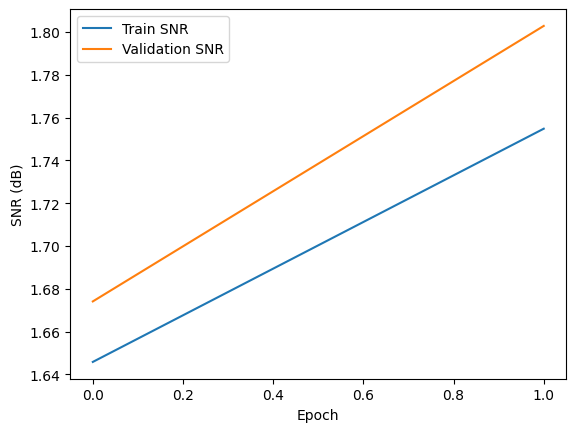

In [40]:
plt.plot(history["train_snr"], label="Train SNR")
plt.plot(history["val_snr"], label="Validation SNR")
plt.xlabel("Epoch")
plt.ylabel("SNR (dB)")
plt.legend()
plt.show()

In [26]:
with zipfile.ZipFile('C:\\Users\\Lukas\\Desktop\\TH Nürnberg\\Projekt\\netz\\Daten\\Test_Vocals_Mix_2473.zip', 'r') as zipf:
    zipf.extractall()  # Entpackt alle Dateien
    
    # Lade die Arrays
    X_test = np.load('X_train.npy', allow_pickle=True)
    y_test = np.load('y_train.npy', allow_pickle=True)

print(X_test.shape)
print(y_test.shape)

(2473, 512, 128, 1)
(2473, 512, 128, 1)


In [27]:
# Evaluierung mit den Testdaten

test_snr = []
for i in range(len(X_test)):
    print(i, "/", len(X_test), end='\r')
    mask = model(tf.expand_dims(X_test[i], axis=0), training=False)
    snr = snr_metric_mask(y_test[i], mask, X_test[i])
    #print(f"{i}: {snr}")
    test_snr.append(snr)


avg_test_snr = np.mean(test_snr)
print(f"Test SNR = {avg_test_snr:.4f}")

Test SNR = 3.1200


In [34]:
train_loss = history["train_loss"]
train_snr = history["train_snr"]
val_loss = history["val_loss"]
val_snr = history["val_snr"]

meta_parameter = []
meta_parameter.append(adjusted_learning_rate)
meta_parameter.append(epoch)

# Speichere die Arrays in einer .zip-Datei
with zipfile.ZipFile(f'C:\\Users\\Lukas\\Desktop\\TH Nürnberg\\Projekt\\netz\\Mid_Training_03_03_SNR={avg_test_snr:.4f}_Epoche={epoch+1}.zip', 'w') as zipf:
    # Speichere jedes Array als separate .npy-Datei
    np.save('train_loss.npy', train_loss)
    np.save('train_snr.npy', train_snr)
    np.save('val_loss.npy', val_loss)
    np.save('val_snr.npy', val_snr)

    np.save('meta_parameter.npy', meta_parameter)
    model.save("model_training.h5")
    
    # Füge die .npy-Dateien zur .zip hinzu
    zipf.write('train_loss.npy')
    zipf.write('train_snr.npy')
    zipf.write('val_loss.npy')
    zipf.write('val_snr.npy')

    zipf.write('meta_parameter.npy')
    zipf.write('model_training.h5')

os.remove('train_loss.npy')
os.remove('train_snr.npy')
os.remove('val_loss.npy')
os.remove('val_snr.npy')

os.remove('meta_parameter.npy')
os.remove('model_training.h5')

In [21]:
def preprocess(array, target_size=(512, 128)):
    n_fft = 512
    hop_length = 128
    win_length = 512

    original_max_amplitude = np.max(np.abs(array))
    stft = librosa.stft(array, n_fft=n_fft, hop_length=hop_length, win_length=win_length)
    stft_magnitude = np.abs(stft)
    phase = np.angle(stft)

    stft_magnitude = np.nan_to_num(stft_magnitude, nan=0.0, posinf=0.0, neginf=0.0)
    # Prüfen, ob das Array leer oder lautlos ist
    if np.max(stft_magnitude) == 0:  # Kein hörbares Signal
        mag_norm = np.zeros_like(stft_magnitude)
    else:
        mag_norm = stft_magnitude / np.max(stft_magnitude)
    
    # Sicherstellen, dass magnitude ein Tensor ist
    magnitude = tf.convert_to_tensor(mag_norm)
    
    # Füge eine Kanaldimension hinzu, falls nicht vorhanden
    if len(magnitude.shape) == 2:  # Nur Height und Width vorhanden
        magnitude = tf.expand_dims(magnitude, axis=-1)  # -> (Height, Width, 1)
    
    # Resize das Spektrogramm
    magnitude_resized = tf.image.resize(magnitude, target_size)
    return magnitude_resized, phase, original_max_amplitude

In [22]:
def postprocess(after, original_max_amplitude, phase):
    n_fft = 512
    hop_length = 128
    win_length = 512
    after_resized = tf.image.resize(after, (257, 1723))

    after_resized = np.squeeze(after_resized, axis=-1)

    #after_resized = after_resized.numpy()

    after_resized = after_resized * original_max_amplitude

    complex_spectrogram = after_resized * np.exp(1j * phase)
    print(complex_spectrogram.shape)
    audio_reconstructed = librosa.istft(complex_spectrogram, hop_length=hop_length, win_length=win_length)
    #audio_reconstructed = librosa.griffinlim(complex_spectrogram, hop_length=hop_length, win_length=win_length)
    return audio_reconstructed

In [23]:
# Funktionen zum Visualizieren der Waveform und Spectrogram

def show_wav(sources):
    if isinstance(sources, list):
        sources = {f'Source {i}': s for i, s in enumerate(sources)}
    plt.figure(figsize=(10, 5))
    plt.plot()
    nussl.core.utils.visualize_sources_as_waveform(sources)
    plt.show()

def show_1wav(data):
    plt.figure(figsize=(10, 5))
    plt.plot()
    nussl.core.utils.visualize_waveform(data)
    plt.show()

def show_fre(sources):
    if isinstance(sources, list):
        sources = {f'Source {i}': s for i, s in enumerate(sources)}
    plt.figure(figsize=(10, 5))
    plt.plot()
    nussl.core.utils.visualize_sources_as_masks(sources, db_cutoff=-80)
    plt.tight_layout()
    plt.show()

def show_1fre(data):
    plt.figure(figsize=(10, 5))
    plt.plot()
    nussl.core.utils.visualize_spectrogram(data)
    plt.show()

Abtastrate: 44100, Länge: 200.52678004535147 Sekunden
(220500,)
(512, 128, 1)
(1, 512, 128, 1)
(1, 512, 128, 1)
(257, 1723)


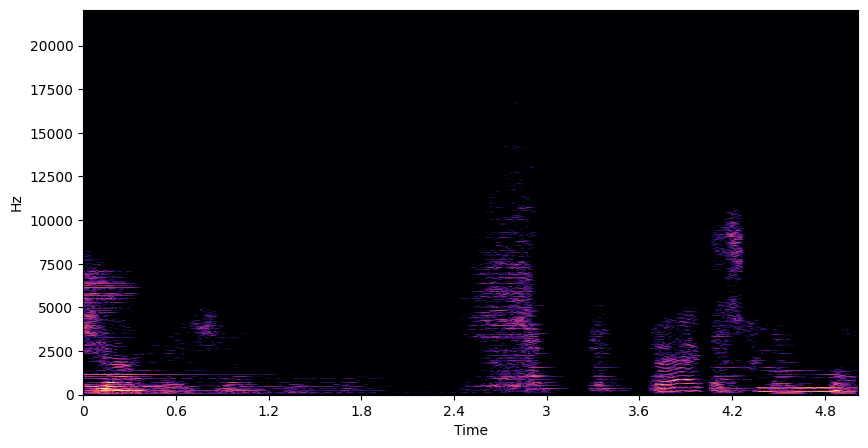

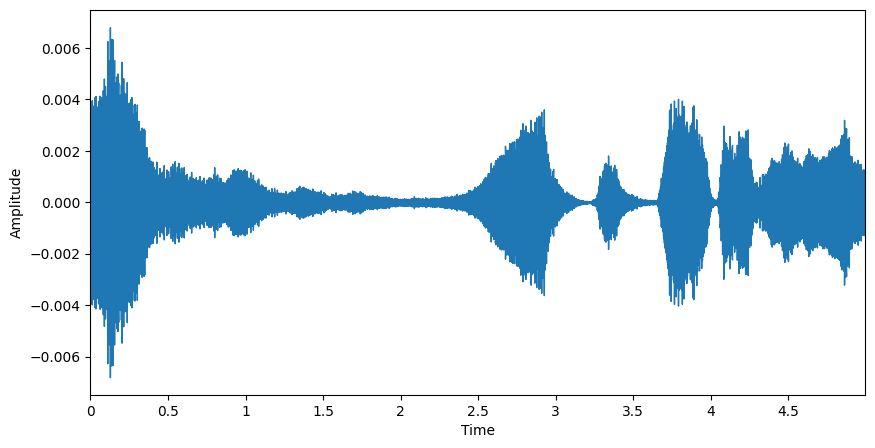

In [41]:
# Test mit Trainingsdaten
path = "C:\\Users\\Lukas\\Desktop\\TH Nürnberg\\Projekt\\musdb18hq\\test\\Al James - Schoolboy Facination\\mixture.wav"

# Audio laden
y, sr = librosa.load(path , sr=None)  # sr=None behält die Original-Abtastrate
print(f"Abtastrate: {sr}, Länge: {len(y) / sr} Sekunden")
#display(Audio(data=y, rate=sr))

s5 = sr * 5

x1 = y[0:s5]
x2 = y[s5:2 * s5]

before = x2  # Ihr Originalsignal
print(before.shape)

after, ph, max = preprocess(before)
print(after.shape)

mask = model(tf.expand_dims(after, axis=0), training=False)
print(mask.shape)
#mask = np.squeeze(mask, axis=-1)
print(mask.shape)

neu = mask[0] * after

vocals = postprocess(neu, max, ph)

song = nussl.AudioSignal()
song.audio_data = vocals
show_1fre(song)
show_1wav(song)
display(Audio(data=song.audio_data, rate=sr))

(220500,)
(257, 1723)
Mix:


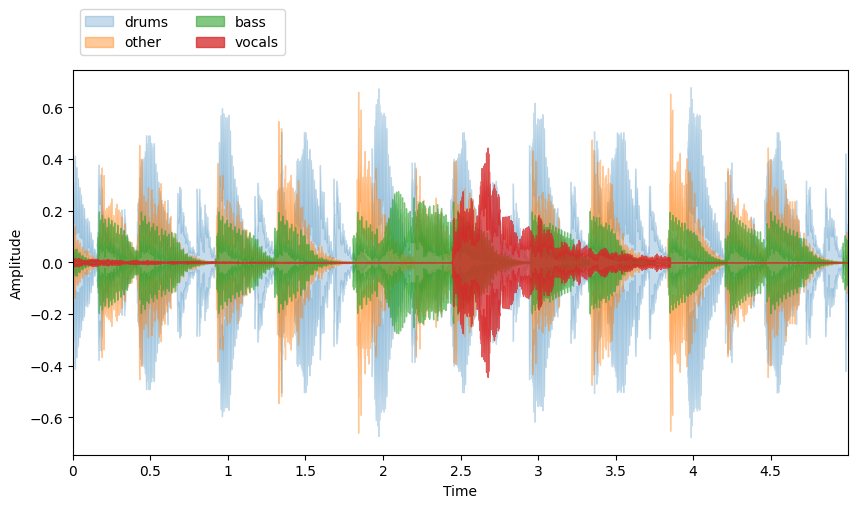

Vocals:


nach model:


Ziel Amplitudenverlauf:


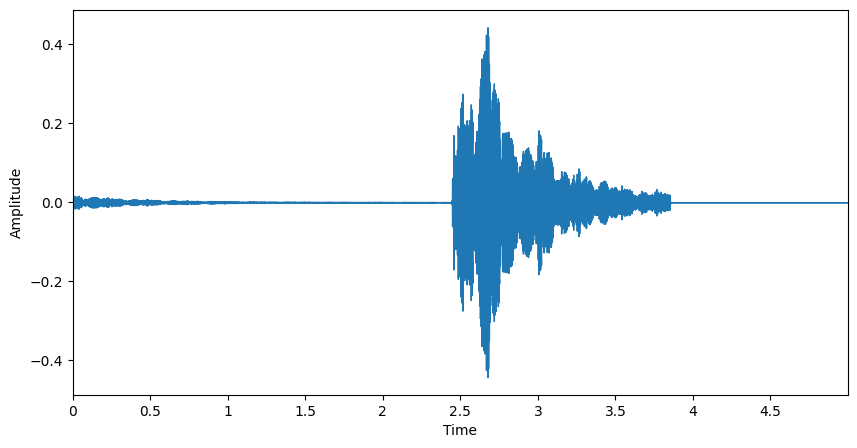

Amplitudenverlauf nach Model:


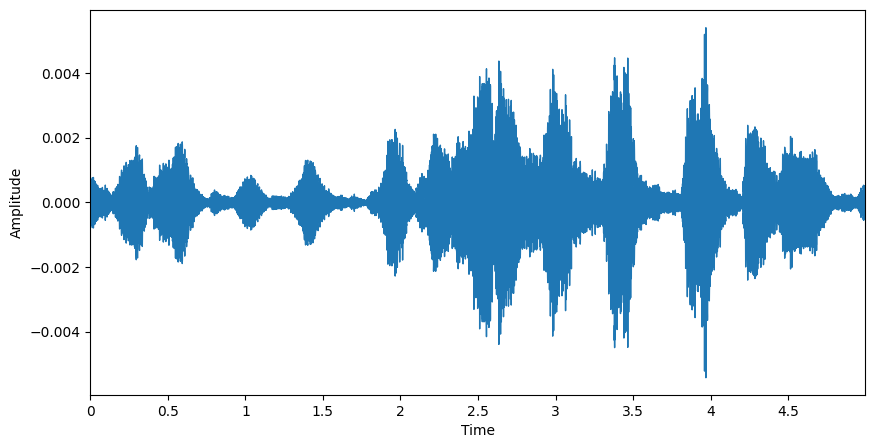

Ziel Spektogram:


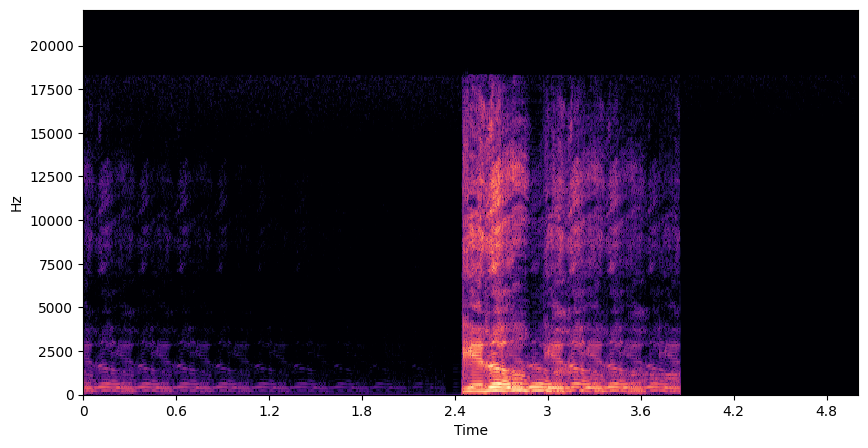

Spektogram nach Model:


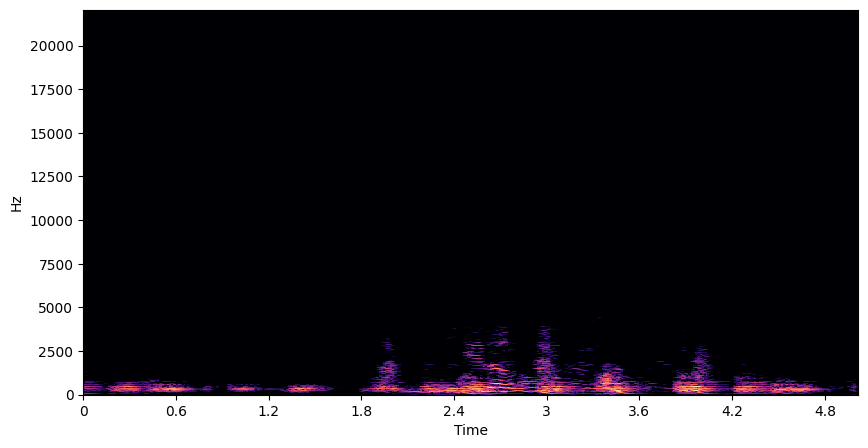

In [43]:
song_id = 15 # 15 20 30

# STFT Parameter setzen
stft_params = nussl.STFTParams(window_length=512, hop_length=128, window_type='sqrt_hann')
#stft_params = nussl.STFTParams(window_length=1024, hop_length=256, window_type='sqrt_hann')

# Pfad zu den Trainingsdaten festlegen
fg_path = "C:\\Users\\Lukas\\nussl_tutorial\\train"

# Trainingsdaten mit `nussl` laden
train_data = data.on_the_fly(stft_params, transform=None, fg_path=fg_path, num_mixtures=2000, coherent_prob=0.1)

# Testdaten laden
test_path = "C:\\Users\\Lukas\\nussl_tutorial\\test"
test_data = data.on_the_fly(stft_params, transform=None, fg_path=test_path, num_mixtures=100)

#song_id = 15
# 15 20 30

test_item = test_data[song_id]
mix = test_item['mix']
mix_array = mix.audio_data[0]
print(mix_array.shape)
vocals = test_item['sources']['vocals']

mix_mag, ph, max = preprocess(mix_array)
mask = model(tf.expand_dims(mix_mag, axis=0), training=False)

neu = mask[0] * mix_mag

audi = postprocess(neu, max, ph)

audio_vocal = nussl.AudioSignal()
audio_vocal.audio_data = audi

item = test_data[song_id]

# Orginaldaten
print('Mix:')
display(Audio(data=item['mix'].audio_data, rate=item['mix'].sample_rate))
#print(item.keys())
show_wav(item['sources'])
#show_fre(item['sources'])

print('Vocals:')
display(Audio(data=item['sources']['vocals'].audio_data, rate=item['mix'].sample_rate))

# Audio nach Model
print('nach model:')
display(Audio(data=audio_vocal.audio_data, rate=item['mix'].sample_rate))

print('Ziel Amplitudenverlauf:')
show_1wav(data=item['sources']['vocals'])
print('Amplitudenverlauf nach Model:')
show_1wav(audio_vocal)

print('Ziel Spektogram:')
show_1fre(data=item['sources']['vocals'])
print('Spektogram nach Model:')
show_1fre(audio_vocal)